In [16]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset
from HiCMap import HiCMap
from ConfigDataset import ConfigDataset
sys.path.insert(2,'../diffusion/')
from classifier_free_guidance_greg import Unet, GaussianDiffusion

In [2]:
chrom = '1' 
region_idx = 395#200#144
nbeads = 64
embeddings_nbeads = 65 
sample_directory = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_final_embeddings/'
cond_scales = [k/10 for k in range(10)]#[0.5,1.,2.,3.,4.,5.]
rescaled_phis = [k/10 for k in range(10)]

In [3]:
config_ds = ConfigDataset(
    filepath='../../data/processed_data.hdf5',
    segment_length=nbeads,
    allow_overlap=True,
    chroms = [chrom],
    replicates=[1]
)

In [4]:
exp_hic = HiCDataset()

In [5]:
#emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings/chrom_{chrom}.tar.gz'
emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings_{embeddings_nbeads}/chrom_{chrom}.tar.gz'
embeddings = pd.read_pickle(emb_fp(chrom))

In [6]:
def get_tan_coords(region_idx=region_idx,embeddings=embeddings):
    _,chrom,start_idx = embeddings.index[region_idx]
    _,coords = config_ds.fetch_specific_coords(chrom,start_idx)
    return coords

In [161]:
def remove_diagonal(x):
    s = x.shape[-1]
    i,j = torch.triu_indices(s,s,1)
    x2 = torch.empty(*x.shape[:-2],s-1,s-1,dtype=x.dtype,device=x.device)
    x2[...,i,j-1] = x[...,i,j]
    x2[...,j-1,i] = x[...,j,i]
    return x2

def add_diagonal(x,diag_value=0):
    s = x.shape[-1]
    i,j = torch.triu_indices(s,s,0)
    x2 = torch.empty(*x.shape[:-2],s+1,s+1,dtype=x.dtype,device=x.device)
    x2[...,i,j+1] = x[...,i,j]
    x2[...,j+1,i] = x[...,j,i] 
    i = torch.arange(s+1)
    x2[...,i,i] = diag_value
    return x2
    
def get_tan_sample(region_idx=region_idx,embeddings=embeddings):
    coords = get_tan_coords(region_idx,embeddings)
    dists = torch.cdist(coords,coords)
    return Sample(data=remove_diagonal(dists))

In [8]:
def get_exp_map(region_idx,exp_hic=exp_hic,emb_idx=embeddings.index,interp_nans=True,region_length=nbeads*20_000):#None): 

    # Get the region information from the embedding index used during sample generation
    region_length1, chrom, start = emb_idx[region_idx]
    region_length = region_length1 if region_length is None else region_length
    stop = start + region_length
    
    return exp_hic.fetch(chrom=chrom,start=start,stop=stop,interp_nans=interp_nans)

In [9]:
_,chrom_,si = embeddings.index[region_idx]
assert chrom == chrom_ 
def compare_to_exp(gen_map,region_index=region_idx):
    exp_map = get_exp_map(region_index)
    pcc = gen_map.pcc(exp_map)
    fig,ax,im,cbar = exp_map.plot_with(gen_map)
    ax.set_title(f'Chrom {chrom}, {si}-{si+nbeads*20_000}\nPCC: {pcc}')
    return fig, ax, im, cbar

In [10]:
#######################
# If new samples should be generated 
consider_generation = False

if consider_generation: 
    embedding_dimensions = (1,260,256)
    milestone = 120
    #fp = f'./results_small/model-{milestone}.pt'
    fp = f'../../data/models/diffusion_small/model-{milestone}.pt'
    
    num_beads = 65
    two_channels = False
    
    c,image_size = 1+int(two_channels), num_beads-1
    model = Unet(
        dim=64,
        #num_classes,
        cond_drop_prob = 0.5,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = c,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        attn_dim_head = 32,
        attn_heads = 4,
        embedding_dimensions=embedding_dimensions
    )
    
    diffusion = GaussianDiffusion(
        model,
        image_size=image_size,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        ddim_sampling_eta = 1.,
        offset_noise_strength = 0.,
        min_snr_loss_weight = False,
        min_snr_gamma = 5
    )
    
    try: 
        diffusion.to('cuda')
    except:
        pass
    
    diffusion.load(fp)

    def generate_new_sample(
        region_idx,
        nconfigs=1000,
        cond_scale=1.,
        rescaled_phi=.7,
        embeddings=embeddings,
        diffusion=diffusion
    ):
        
        emb = embeddings.iloc[region_idx,0].to(diffusion.device).expand(nconfigs,-1,-1,-1)
        
        sample = Sample(
            data = diffusion.sample(emb,cond_scale=cond_scale,rescaled_phi=rescaled_phi)
        )
        #sample.to('cpu')
        #pickle.dump(sample,open(f'./sampling_small/sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl','wb'))

        return sample 

In [17]:
def load_sample(
    filepath = None,
    directory=sample_directory, #'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/diffusion_v1/sampling_small/',
    region_idx=0,
    cond_scale=1.,
    rescaled_phi=.7,
    milestone=69,
    chrom=1
):

    if filepath is None: 
        if directory != '' and directory[-1] != '/':
            directory+= '/'

        fp = f'{directory}sample_{region_idx}_{cond_scale}_{rescaled_phi}_{milestone}_{chrom}.pkl'
        if not os.path.exists(fp):
            fp = f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'
    else: 
        fp = filepath 
    data = pd.read_pickle(fp).unflatten()
    if len(data.shape) == 2: 
        data = data.unsqueeze(0)
    #if len(data.shape) == 3:
    #    data = data.unsqueeze(1)

    return Sample(data=data)
    #return pd.read_pickle(fp)
    #return Sample(data=pd.read_pickle(fp).batch)
    


(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f3de0e1d630>)

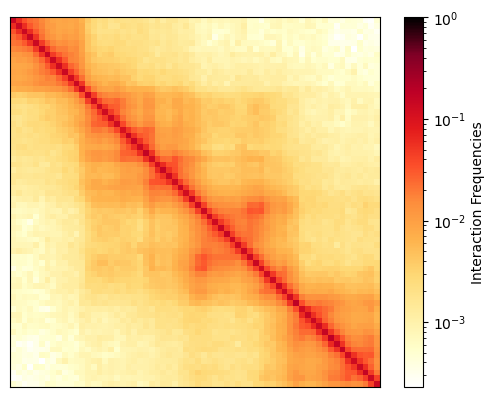

In [18]:
exp_probs = get_exp_map(region_idx)
# Interesting possibles: 265, 330!, 395, 525?, 
exp_probs.plot()

Load the generated samples

In [19]:
sample = load_sample(
    region_idx=region_idx,
    cond_scale=1.,
    rescaled_phi=0.,
    milestone=120,
    chrom = chrom
)

DON'T correct the distance maps before computing probabilities. Need a special function for that

In [137]:
def tanh_map(sample,r_c,sigma):
    '''
    Avoids using the distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.unflatten()

    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**4
    
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)

def thresh_map(sample,r_c):
    '''
    Avoid using distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.unflatten()

    below_thresh = (r < r_c).float()
    below_thresh[r.isnan()] = torch.nan
    
    return HiCMap(torch.nanmean(below_thresh,dim=0).squeeze(),includes_self_interaction=False)
    

In [21]:
# Get the best r_c & sigma values

r_cs = torch.arange(1,2.5,.01)
sigmas = torch.arange(.5,6,.1)
N = len(r_cs) * len(sigmas)
n=0

best_pcc = -2
r_c = -1
sigma = -1
for r_c_ in r_cs:
    for sigma_ in sigmas:
        probs = tanh_map(sample,r_c_,sigma_)
        pcc = probs.pcc(exp_probs)
        if pcc > best_pcc: 
            best_pcc = pcc
            r_c = r_c_
            sigma = sigma_
        n+=1 
        if n % 250 == 0:
            print(f'{n/N*100}% complete')
print(f'Best PCC: {best_pcc}')
print(f'Best r_c: {r_c}')
print(f'Best sigma: {sigma}')

KeyboardInterrupt: 

In [22]:
r_c = 1.6 
sigma = 6

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Chrom 1, 8680000-9960000\nPCC: 0.767626964951707'}>,
 <matplotlib.colorbar.Colorbar at 0x7f3de0955510>)

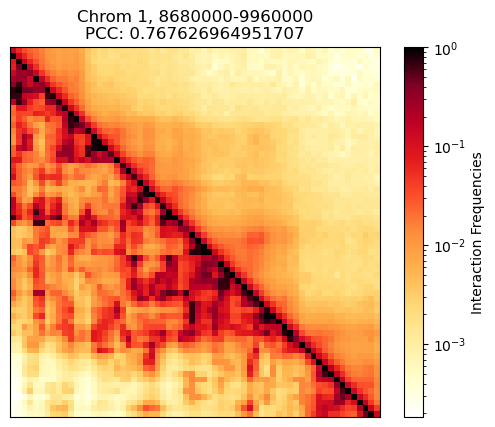

In [23]:
gen_probs_uncorrected = tanh_map(sample,r_c,sigma)
compare_to_exp(gen_probs_uncorrected)

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f3de0dc5390>)

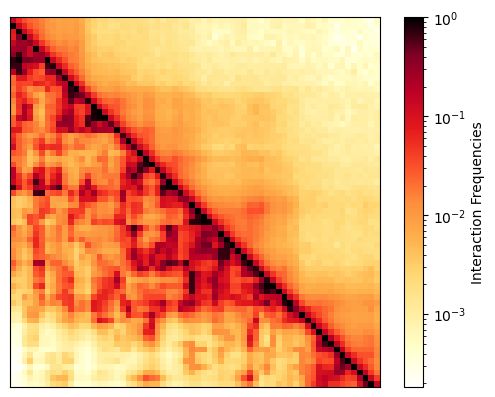

In [24]:
gen_probs_uncorrected = tanh_map(sample,r_c,sigma)
exp_probs.plot_with(gen_probs_uncorrected)
#gen_probs_uncorrected.plot()

Correct the distance maps before computing probabilities

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f3de00118a0>)

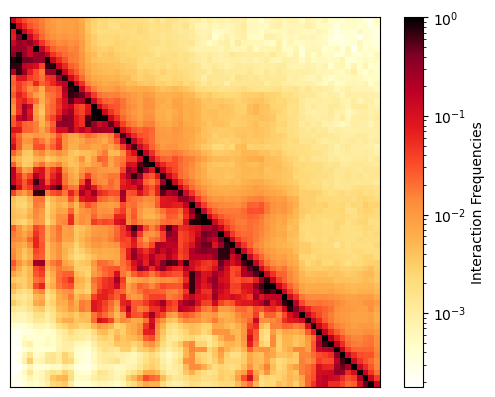

In [25]:
gen_probs = sample.contact_probabilities(r_c=r_c,sigma=sigma)
exp_probs.plot_with(gen_probs)
#gen_probs.plot()

Compare them!

In [26]:
# Corrected vs uncorrected generated maps
gen_probs.pcc(gen_probs_uncorrected)

tensor(0.9992, dtype=torch.float64)

In [27]:
# Corrected vs experimental map
gen_probs.pcc(exp_probs)

tensor(0.7586, dtype=torch.float64)

In [28]:
# Uncororrected vs experimental map
gen_probs_uncorrected.pcc(exp_probs)

tensor(0.7676, dtype=torch.float64)

In [29]:
sample = load_sample(
    region_idx=region_idx,
    cond_scale=5.,
    rescaled_phi=0.0,
    milestone=120,
    chrom = chrom
)

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f3ddff39b70>)

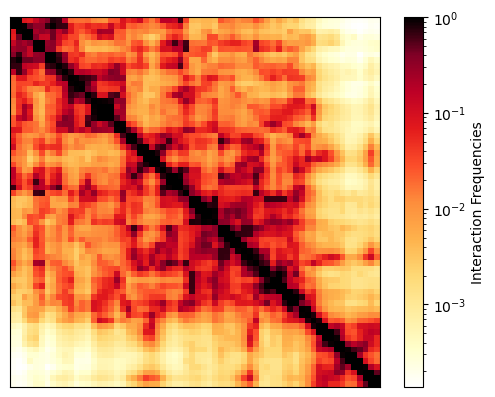

In [30]:
temp = tanh_map(sample,r_c,sigma)
temp.plot()#vmin=10e-4)

In [31]:
temp.pcc(exp_probs)

tensor(0.7635, dtype=torch.float64)

In [32]:
dists = sample.unflatten()

In [33]:
dists.squeeze().std(dim=0)

tensor([[0.1585, 0.0882, 0.3089,  ..., 0.9914, 1.1687, 0.6823],
        [0.0882, 0.2391, 0.4469,  ..., 1.5214, 1.6893, 1.1116],
        [0.3089, 0.4469, 0.1898,  ..., 1.9631, 2.1502, 1.5929],
        ...,
        [0.9914, 1.5214, 1.9631,  ..., 0.0969, 0.3109, 0.4534],
        [1.1687, 1.6893, 2.1502,  ..., 0.3109, 0.3826, 0.3274],
        [0.6823, 1.1116, 1.5929,  ..., 0.4534, 0.3274, 0.0617]],
       dtype=torch.float64)

In [34]:
fp = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_final_embeddings/sample_unguided_120.pkl'
dists2 = load_sample(fp)
dists2.unnormalize_()
dists2 = dists2.unflatten()
dists2.squeeze().std(dim=0)

tensor([[0.4640, 0.8008, 0.9114,  ..., 3.7148, 3.5391, 3.4455],
        [0.8008, 0.5299, 0.6058,  ..., 3.6913, 3.5055, 3.3696],
        [0.9114, 0.6058, 0.4257,  ..., 3.6564, 3.4934, 3.3848],
        ...,
        [3.7148, 3.6913, 3.6564,  ..., 0.3927, 0.6536, 0.7389],
        [3.5391, 3.5055, 3.4934,  ..., 0.6536, 0.4362, 0.7708],
        [3.4455, 3.3696, 3.3848,  ..., 0.7389, 0.7708, 0.4101]],
       dtype=torch.float64)

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f3ddcc149a0>)

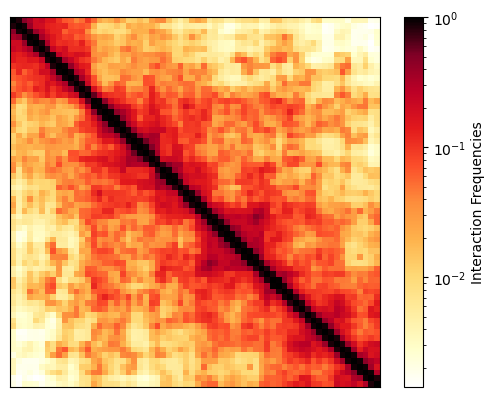

In [35]:
sample_tan = get_tan_sample()
tan_map = tanh_map(sample_tan,r_c,sigma)
tan_map.plot()

In [36]:
tan_map.pcc(gen_probs_uncorrected)

tensor(0.7884, dtype=torch.float64)

In [37]:
tan_map.pcc(exp_probs)

tensor(0.9444, dtype=torch.float64)

In [38]:
sample_tan.unflatten().squeeze().std(0)

tensor([[0.5776, 0.7335, 0.7410,  ..., 3.8361, 3.7290, 3.8387],
        [0.7335, 0.4464, 0.6722,  ..., 3.8337, 3.7702, 3.8845],
        [0.7410, 0.6722, 0.5163,  ..., 3.9977, 3.9266, 4.0164],
        ...,
        [3.8361, 3.8337, 3.9977,  ..., 0.4010, 0.6004, 0.8097],
        [3.7290, 3.7702, 3.9266,  ..., 0.6004, 0.3379, 0.6637],
        [3.8387, 3.8845, 4.0164,  ..., 0.8097, 0.6637, 0.5138]],
       dtype=torch.float64)

Now scan over many rescaled phi/cond scale values

In [39]:
pccs = []
scales = []
phis = []
best_pcc = -2
best_scale = -1
best_phi = -1
for cond_scale in cond_scales: 
    for rescaled_phi in rescaled_phis: 
        try: 
            sample = load_sample(
                region_idx=region_idx,
                cond_scale=cond_scale,
                rescaled_phi=rescaled_phi,
                milestone=120,
                chrom = chrom
            )
        except:
            #if n % 10 == 0:
            #    print(f'{n/N*100}% completed')
            #    print(f'Best PCC so far: {best_pcc}')
            #    print('')
            continue
        temp_probs = tanh_map(sample,r_c,sigma)
        pccs.append(temp_probs.pcc(exp_probs))
        scales.append(cond_scale)
        phis.append(rescaled_phi)
        if pccs[-1] > best_pcc:
            best_pcc = pccs[-1]
            best_scale = cond_scale
            best_phi = rescaled_phi

print(f'Best PCC:\t{best_pcc}')
print(f'Best Scale:\t{best_scale}')
print(f'Best Rescale:\t{best_phi}')

Best PCC:	0.9210861491957523
Best Scale:	0.2
Best Rescale:	0.2


(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f3ddc9af0a0>)

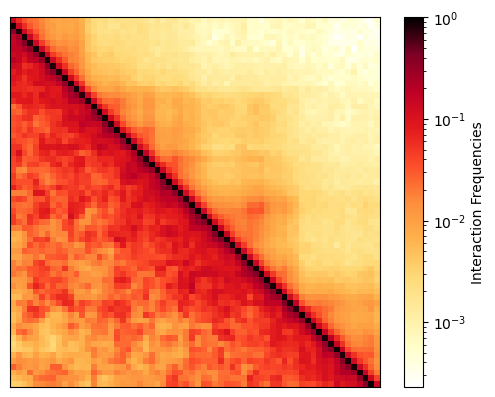

In [40]:
sample = load_sample(
    region_idx=region_idx,
    cond_scale=best_scale,
    rescaled_phi=best_phi,
    milestone=120,
    chrom = chrom
)
gen_probs_uncorrected = tanh_map(sample,r_c,sigma)
#gen_probs_uncorrected.plot()
exp_probs.plot_with(gen_probs_uncorrected)

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f3ddc92fb50>)

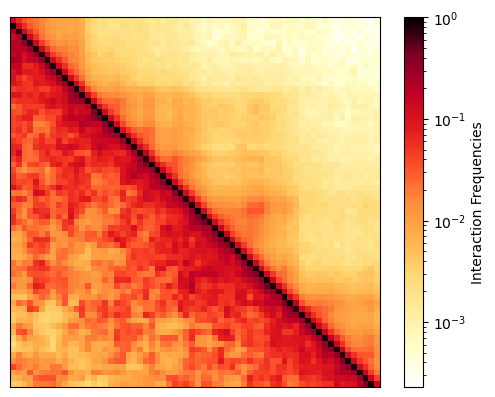

In [41]:
gen_probs = sample.contact_probabilities(r_c=r_c,sigma=sigma)
#gen_probs.plot()
exp_probs.plot_with(gen_probs)

In [42]:
gen_probs.pcc(gen_probs_uncorrected)

tensor(0.9952, dtype=torch.float64)

In [43]:
gen_probs.pcc(exp_probs)

tensor(0.9190, dtype=torch.float64)

In [44]:
gen_probs_uncorrected.pcc(exp_probs)

tensor(0.9211, dtype=torch.float64)

In [45]:
# Get the best r_c & sigma values

r_cs = torch.arange(1,2.5,.01)
sigmas = torch.arange(.5,6,.1)
N = len(r_cs) * len(sigmas)
n=0

best_pcc = -2
r_c = -1
sigma = -1
for r_c_ in r_cs:
    for sigma_ in sigmas:
        probs = tanh_map(sample,r_c_,sigma_)
        pcc = probs.pcc(exp_probs)
        if pcc > best_pcc: 
            best_pcc = pcc
            r_c = r_c_
            sigma = sigma_
        n+=1 
        if n % 250 == 0:
            print(f'{n/N*100}% complete')
print(f'Best PCC: {best_pcc}')
print(f'Best r_c: {r_c}')
print(f'Best sigma: {sigma}')

3.0303030303030303% complete
6.0606060606060606% complete
9.090909090909092% complete
12.121212121212121% complete
15.151515151515152% complete


KeyboardInterrupt: 

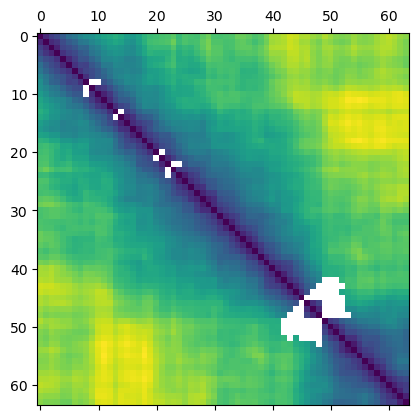

In [74]:
plt.matshow(nanstd(add_diagonal(sample.unflatten()),dim=0).squeeze())

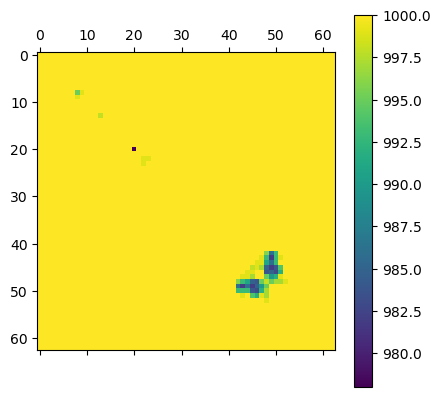

In [80]:
plt.matshow(sample.unflatten().squeeze().isfinite().sum(0).numpy())
plt.colorbar()

In [87]:
def nanstd(x,dim=None):
    return ( torch.nanmean(x**2,dim=dim) - torch.nanmean(x,dim=dim)**2 ).sqrt()
    
def get_std(sample):
    x = sample.unflatten().squeeze()
    x[~x.isfinite()] = torch.nan
    return nanstd(x,dim=0)

def get_mean(sample):
    x = sample.unflatten().squeeze()
    x[~x.isfinite()] = torch.nan
    return torch.nanmean(x,dim=0)

In [135]:
def plot_stats_2d(mean_gen,fig=None,ax=None,distances=True):

    if ax is None and fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)
        
    im = ax.matshow(mean_gen.prob_map.numpy(),cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = fig.colorbar(
        im,
        label = 'Distance' if distances else 'Distance Standard Deviation',
        ax=ax
    )
    
    return fig, ax, im, cbar

def plot_stats_1d(mean_gen,fig=None,ax=None,distances=True):

    x = mean_gen.prob_map.numpy()
    i,j = torch.triu_indices(x.shape[-1],x.shape[-1],1)

    x,y = x[i,j], x[j,i]

    v = [max(x.min(),y.min()),min(x.max(),y.max())]

    if ax is None and fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)
    ax.plot(x,y,'.')
    ax.plot(v,v)
    if distances:
        ax.set_xlabel('Mean Distances: Tan Dataset')
        ax.set_ylabel('Mean Distances: Generated Data')
    else:
        ax.set_xlabel('Distance Standard Deviation: Tan Dataset')
        ax.set_ylabel('Distance Standard Deviation: Generated Data')
    
    return fig,ax

def plot_stats(sample,sample_tan):

    std_tan = HiCMap(sample_tan.unflatten().std(0))
    mean_tan = HiCMap(sample_tan.unflatten().mean(0))

    std_gen = HiCMap(get_std(sample))
    std_gen.replace_lower_triangle(std_tan)
    std_gen.T_()

    mean_gen = HiCMap(get_mean(sample))
    mean_gen.replace_lower_triangle(mean_tan)
    mean_gen.T_()

    ########
    # plots
    fig = plt.figure(figsize=(10,7.5))
    ax1 = fig.add_subplot(221)
    plot_stats_2d(mean_gen,fig=fig,ax=ax1,distances=True)
    ax2 = fig.add_subplot(222)
    plot_stats_1d(mean_gen,fig=fig,ax=ax2,distances=True)
    ax3 = fig.add_subplot(223)
    plot_stats_2d(std_gen,fig=fig,ax=ax3,distances=False)
    ax4 = fig.add_subplot(224)
    plot_stats_1d(std_gen,fig=fig,ax=ax4,distances=False)

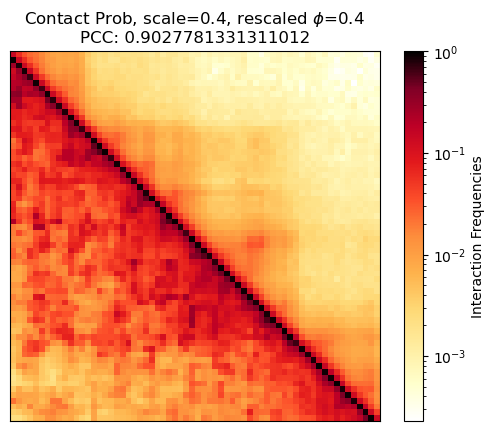

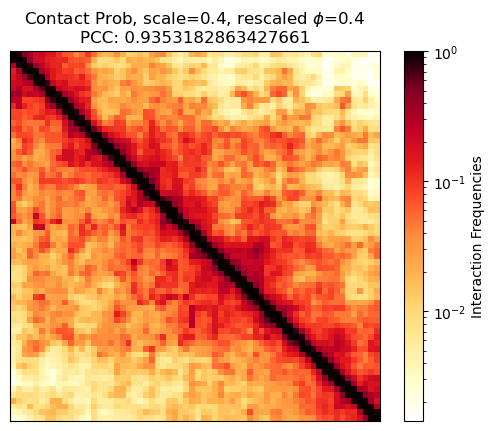

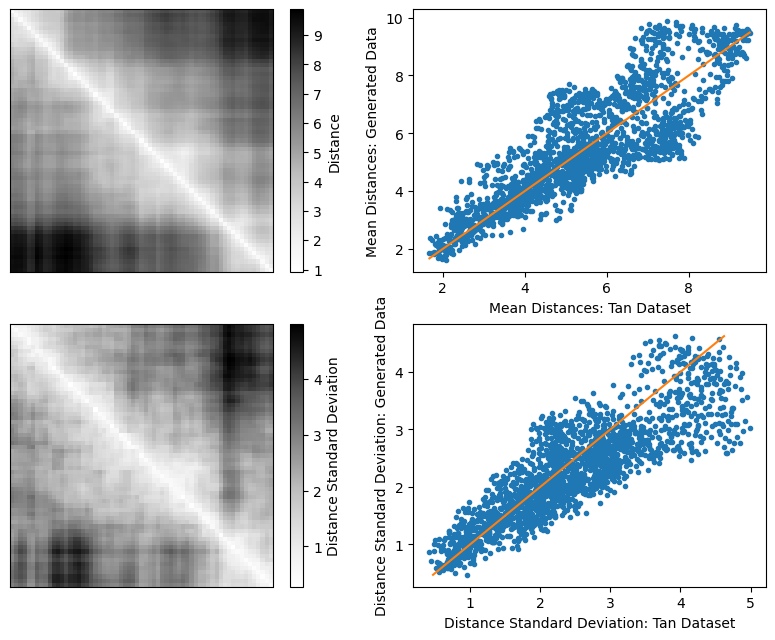

In [164]:

r_c = 1.6#1.6
rescaled_phi = .4
sigma = 6 
std_tan = HiCMap(sample_tan.unflatten().std(0))
mean_tan = HiCMap(sample_tan.unflatten().mean(0))
for cond_scale in [.4]:#[k/10 for k in range(1,10)]:
    sample = load_sample(
        region_idx=region_idx,
        cond_scale=cond_scale,#best_scale,
        rescaled_phi=rescaled_phi,#best_phi,
        milestone=120,
        chrom = chrom
    )
    
    gen_probs_uncorrected = tanh_map(sample,r_c,sigma)
    #gen_probs_uncorrected = thresh_map(sample,r_c)
    
    _,ax,_,_ = exp_probs.plot_with(gen_probs_uncorrected)
    ax.set_title(
        f'Contact Prob, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
        f'PCC: {exp_probs.pcc(gen_probs_uncorrected)}'
    )
    

    _,ax,_,_ = tan_map.plot_with(gen_probs_uncorrected)
    ax.set_title(
        f'Contact Prob, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}\n'+\
        f'PCC: {tan_map.pcc(gen_probs_uncorrected)}'
    )

    '''
    # plot the standard deviations of distance compared to the tan dataset
    std_gen = HiCMap(get_std(sample))#nanstd(sample.unflatten(),dim=0).squeeze())#sample.unflatten().squeeze().std(0))
    std_gen.replace_lower_triangle(std_tan)
    std_gen.T_()
    std_gen.prob_map/= std_gen.prob_map.max() # Normalize
    _,ax,_,_ = std_gen.plot(cmap='Greys')
    ax.set_title(f'Distance std, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}')

    # plot the standard deviations of distance compared to the tan dataset
    mean_gen = HiCMap(get_mean(sample))#nanstd(sample.unflatten(),dim=0).squeeze())#sample.unflatten().squeeze().std(0))
    mean_gen.replace_lower_triangle(mean_tan)
    mean_gen.T_()
    mean_gen.prob_map/= mean_gen.prob_map.max() # Normalize
    _,ax,_,cbar = mean_gen.plot(cmap='Greys')
    ax.set_title(f'Mean distances, scale={cond_scale}, rescaled $\\phi$={rescaled_phi}')
    '''
    plot_stats(sample,sample_tan)
    
    #std_tan.replace_lower_triangle(std_gen)
    #std_tan.replace_lower_triangle(std_gen)

In [ ]:
asdf

In [ ]:
new_sample = generate_new_sample(region_idx)

In [ ]:
new_gen_probs = new_sample.contact_probabilities()

In [ ]:
new_gen_probs.plot()
exp_probs.plot()

In [ ]:
import torch
r_cs = torch.arange(1,3.01,.01)
sigmas = torch.arange(.5,8,.25)
pccs = torch.empty(len(r_cs),len(sigmas),dtype=torch.double)
for i,r_c in enumerate(r_cs): 
    for j,sigma in enumerate(sigmas):
        pp = new_sample.contact_probabilities(r_c=r_c,sigma=sigma)
        pccs[i,j] = pp.pcc(exp_probs).cpu()

In [ ]:
plt.matshow(pccs.cpu().numpy())
plt.colorbar()

In [ ]:
pccs = pccs.cpu().numpy()
pccs.max()

In [ ]:
import numpy as np
i,j = np.where(pccs == pccs.max())
best_r_c = float(r_cs[i])
best_sigma = float(sigmas[j])

In [ ]:
new_gen_probs = new_sample.contact_probabilities(r_c=best_r_c,sigma=best_sigma)
new_gen_probs.plot()
exp_probs.plot()

In [ ]:
#import pickle
#pickle.dump(new_sample,open('first_sample.pkl','wb'))

In [ ]:
A = torch.zeros(10,10)
i,j = torch.tril_indices(10,10,1)
A[i,j] = 1
plt.matshow(A)
plt.colorbar()

In [ ]:
int(True)